In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg

print(mmseg.__version__)

/userhome/cs/u3566269/anaconda3/envs/mmseg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu113 True
0.30.0


In [2]:
# # Download CUDA toolkits
# !wget https://developer.download.nvidia.com/compute/cuda/10.1/Prod/local_installers/cuda_10.1.243_418.87.00_linux.run
# !chmod 755 ./cuda_10.1.243_418.87.00_linux.run
# !./cuda_10.1.243_418.87.00_linux.run --silent --toolkit --toolkitpath=$HOME/cuda_10.1 --defaultroot=$HOME/cuda_10.1

In [3]:
#Set env variables
PATH=%env PATH
HOME=%env HOME

%env PATH=$HOME/cuda_10.1/bin:$PATH
%env LD_LIBRARY_PATH=$HOME/cuda_10.1/lib64

env: PATH=/userhome/cs/u3566269/cuda_10.1/bin:/userhome/cs/u3566269/.local/bin:/userhome/cs/u3566269/anaconda3/envs/mmseg/bin:/userhome/cs/u3566269/anaconda3/condabin:/usr/local/slurm/bin:/usr/local/slurm/sbin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
env: LD_LIBRARY_PATH=/userhome/cs/u3566269/cuda_10.1/lib64


In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
# !conda install -y pytorch=1.6.0 torchvision cudatoolkit=10.1 -c pytorch
# # !pip install mmcv-full==latest+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.6.0/index.html


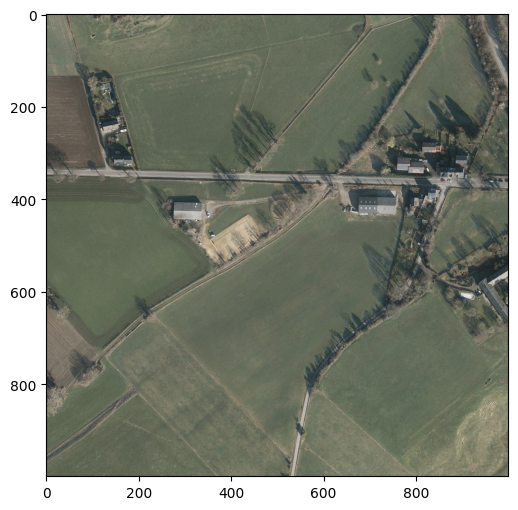

In [6]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('openearth/images/aachen_10.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [7]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'openearth'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization

classes = ['unknown', 'Bareland', 'Grass', 'Pavement', 'Road', 'Tree', 'Water', 'Cropland', 'buildings']
palette = [[0, 0, 0], [128, 0, 0], [0, 255, 36], [148, 148, 148], [255, 255, 255], [34, 97, 38], [0, 69, 255], [75, 181, 73], [222, 31, 7]]

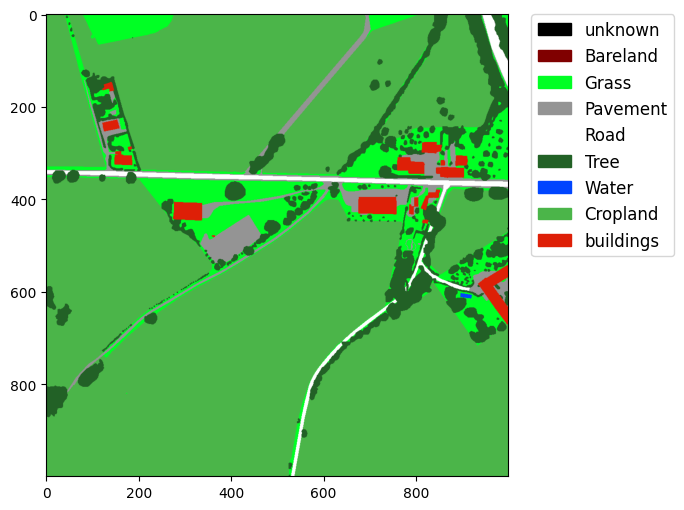

In [8]:
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np

img = Image.open('openearth/labels/aachen_10.png').convert('P')
img.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))

im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(9)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
import os.path as osp
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

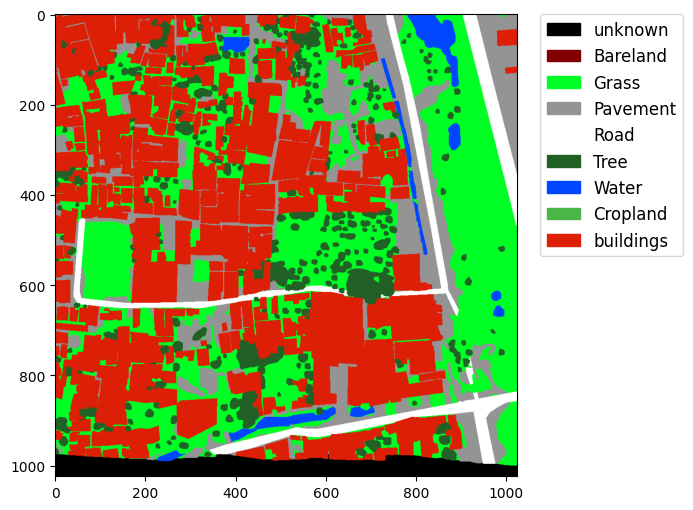

In [10]:
import matplotlib.patches as mpatches
img = Image.open('openearth/labels/dhaka_2.png').convert('P')
img.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))

im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(9)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [11]:
from mmcv import Config
cfg = Config.fromfile('configs/deeplabv3plus/deeplabv3plus_custom.py')

In [12]:
# Since we use ony one GPU, BN is used instead of SyncBN
# # We can still use the pre-trained Mask RCNN model though we do not need to
# # use the mask branch
#cfg.load_from = './work_dirs/openearth/deeplabv3/apr_12_40k/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/openearth/deeplabv3/apr_12_40k'
cfg.gpu_ids = range(1)
cfg.seed = 0
cfg.device = "cuda"

cfg.runner.max_iters = 40000
cfg.log_config.interval = 500
cfg.evaluation.interval = 1000
cfg.checkpoint_config.interval = 10000

# # Set seed to facitate reproducing the result
# cfg.seed = 0
# cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=9,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_in

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor, init_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

print(model.CLASSES)
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2023-04-13 01:31:50,672 - mmseg - INFO - Loaded 2092 images
/userhome/cs/u3566269/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/userhome/cs/u3566269/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


['unknown', 'Bareland', 'Grass', 'Pavement', 'Road', 'Tree', 'Water', 'Cropland', 'buildings']


2023-04-13 01:32:05,956 - mmseg - INFO - Loaded 523 images
2023-04-13 01:32:05,959 - mmseg - INFO - Start running, host: u3566269@gpu2-comp-106, work_dir: /userhome/cs/u3566269/mmsegmentation/work_dirs/openearth/deeplabv3/apr_12_40k
2023-04-13 01:32:05,960 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 --------------------

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 10.4 task/s, elapsed: 51s, ETA:     0s

2023-04-13 01:42:17,409 - mmseg - INFO - per class results:
2023-04-13 01:42:17,412 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.0  |  0.0  |
|  Bareland |  5.6  |  6.27 |
|   Grass   | 22.13 |  34.0 |
|  Pavement |  0.0  |  0.0  |
|    Road   | 37.39 | 85.14 |
|    Tree   |  3.24 |  4.94 |
|   Water   | 20.43 | 43.13 |
|  Cropland | 38.39 | 60.61 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 01:42:17,413 - mmseg - INFO - Summary:
2023-04-13 01:42:17,414 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 39.18 | 15.9 | 29.26 |
+-------+------+-------+
2023-04-13 01:42:17,415 - mmseg - INFO - Iter(val) [523]	aAcc: 0.3918, mIoU: 0.1590, mAcc: 0.2926, IoU.unknown: 0.0000, IoU.Bareland: 0.0560, IoU.Grass: 0.2213, IoU.Pavement: 0.0000, IoU.Road: 0.3739, IoU.Tree: 0.0324, IoU.Water: 0.2043, IoU.Cropland: 0.3839, IoU.buildings: nan, Acc.unknown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 01:52:08,352 - mmseg - INFO - per class results:
2023-04-13 01:52:08,354 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.64 |  0.64 |
|  Bareland | 22.97 | 33.14 |
|   Grass   | 17.76 | 28.94 |
|  Pavement |  2.0  |  2.13 |
|    Road   | 32.12 | 36.63 |
|    Tree   |  4.49 |  5.21 |
|   Water   | 36.18 | 65.28 |
|  Cropland | 39.18 | 88.74 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 01:52:08,356 - mmseg - INFO - Summary:
2023-04-13 01:52:08,357 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 42.88 | 19.42 | 32.59 |
+-------+-------+-------+
2023-04-13 01:52:08,360 - mmseg - INFO - Iter(val) [523]	aAcc: 0.4288, mIoU: 0.1942, mAcc: 0.3259, IoU.unknown: 0.0064, IoU.Bareland: 0.2297, IoU.Grass: 0.1776, IoU.Pavement: 0.0200, IoU.Road: 0.3212, IoU.Tree: 0.0449, IoU.Water: 0.3618, IoU.Cropland: 0.3918, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 02:01:57,150 - mmseg - INFO - per class results:
2023-04-13 02:01:57,152 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.0  |  0.0  |
|  Bareland | 20.86 | 31.99 |
|   Grass   | 27.86 | 40.28 |
|  Pavement | 17.67 | 20.89 |
|    Road   | 44.61 | 88.08 |
|    Tree   | 30.04 | 40.39 |
|   Water   | 30.99 | 42.31 |
|  Cropland | 47.44 | 65.22 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 02:01:57,154 - mmseg - INFO - Summary:
2023-04-13 02:01:57,155 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 49.57 | 27.43 | 41.15 |
+-------+-------+-------+
2023-04-13 02:01:57,157 - mmseg - INFO - Iter(val) [523]	aAcc: 0.4957, mIoU: 0.2743, mAcc: 0.4115, IoU.unknown: 0.0000, IoU.Bareland: 0.2086, IoU.Grass: 0.2786, IoU.Pavement: 0.1767, IoU.Road: 0.4461, IoU.Tree: 0.3004, IoU.Water: 0.3099, IoU.Cropland: 0.4744, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.5 task/s, elapsed: 46s, ETA:     0s

2023-04-13 02:11:46,512 - mmseg - INFO - per class results:
2023-04-13 02:11:46,513 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.0  |  0.0  |
|  Bareland | 28.83 |  41.4 |
|   Grass   | 33.13 | 60.32 |
|  Pavement | 29.92 | 45.12 |
|    Road   | 49.74 | 69.41 |
|    Tree   | 34.21 |  40.7 |
|   Water   | 36.89 | 49.86 |
|  Cropland | 48.94 |  62.5 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 02:11:46,515 - mmseg - INFO - Summary:
2023-04-13 02:11:46,521 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 54.36 | 32.71 | 46.16 |
+-------+-------+-------+
2023-04-13 02:11:46,524 - mmseg - INFO - Iter(val) [523]	aAcc: 0.5436, mIoU: 0.3271, mAcc: 0.4616, IoU.unknown: 0.0000, IoU.Bareland: 0.2883, IoU.Grass: 0.3313, IoU.Pavement: 0.2992, IoU.Road: 0.4974, IoU.Tree: 0.3421, IoU.Water: 0.3689, IoU.Cropland: 0.4894, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 02:21:35,248 - mmseg - INFO - per class results:
2023-04-13 02:21:35,252 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  7.48 |  7.56 |
|  Bareland | 25.49 | 35.27 |
|   Grass   | 30.33 | 69.75 |
|  Pavement |  26.9 | 44.66 |
|    Road   | 42.29 | 58.87 |
|    Tree   | 14.44 | 14.49 |
|   Water   | 43.19 | 63.22 |
|  Cropland | 25.38 | 27.25 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 02:21:35,253 - mmseg - INFO - Summary:
2023-04-13 02:21:35,256 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 47.7 | 26.94 | 40.13 |
+------+-------+-------+
2023-04-13 02:21:35,258 - mmseg - INFO - Iter(val) [523]	aAcc: 0.4770, mIoU: 0.2694, mAcc: 0.4013, IoU.unknown: 0.0748, IoU.Bareland: 0.2549, IoU.Grass: 0.3033, IoU.Pavement: 0.2690, IoU.Road: 0.4229, IoU.Tree: 0.1444, IoU.Water: 0.4319, IoU.Cropland: 0.2538, IoU.buildings: nan, Acc.unknown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 02:31:23,859 - mmseg - INFO - per class results:
2023-04-13 02:31:23,862 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.09 |  0.09 |
|  Bareland |  29.5 | 41.27 |
|   Grass   | 25.56 |  35.3 |
|  Pavement | 28.46 | 35.71 |
|    Road   | 48.57 | 64.36 |
|    Tree   | 23.42 | 23.66 |
|   Water   | 35.01 | 65.78 |
|  Cropland | 47.38 | 83.11 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 02:31:23,865 - mmseg - INFO - Summary:
2023-04-13 02:31:23,867 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 52.78 | 29.75 | 43.66 |
+-------+-------+-------+
2023-04-13 02:31:23,868 - mmseg - INFO - Iter(val) [523]	aAcc: 0.5278, mIoU: 0.2975, mAcc: 0.4366, IoU.unknown: 0.0009, IoU.Bareland: 0.2950, IoU.Grass: 0.2556, IoU.Pavement: 0.2846, IoU.Road: 0.4857, IoU.Tree: 0.2342, IoU.Water: 0.3501, IoU.Cropland: 0.4738, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 02:41:15,325 - mmseg - INFO - per class results:
2023-04-13 02:41:15,327 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.07 |  0.08 |
|  Bareland | 30.83 | 47.67 |
|   Grass   | 35.57 | 59.06 |
|  Pavement | 33.07 | 39.32 |
|    Road   | 50.87 | 66.35 |
|    Tree   | 36.37 | 54.17 |
|   Water   | 41.22 | 70.93 |
|  Cropland | 48.96 | 56.04 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 02:41:15,330 - mmseg - INFO - Summary:
2023-04-13 02:41:15,331 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 56.19 | 34.62 | 49.2 |
+-------+-------+------+
2023-04-13 02:41:15,335 - mmseg - INFO - Iter(val) [523]	aAcc: 0.5619, mIoU: 0.3462, mAcc: 0.4920, IoU.unknown: 0.0007, IoU.Bareland: 0.3083, IoU.Grass: 0.3557, IoU.Pavement: 0.3307, IoU.Road: 0.5087, IoU.Tree: 0.3637, IoU.Water: 0.4122, IoU.Cropland: 0.4896, IoU.buildings: nan, Acc.unknown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.5 task/s, elapsed: 45s, ETA:     0s

2023-04-13 02:51:08,370 - mmseg - INFO - per class results:
2023-04-13 02:51:08,372 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  0.1  |  0.1  |
|  Bareland | 32.95 |  43.9 |
|   Grass   | 37.22 | 59.76 |
|  Pavement | 37.31 | 47.27 |
|    Road   | 54.36 | 75.89 |
|    Tree   | 31.38 | 32.18 |
|   Water   | 49.52 | 76.27 |
|  Cropland |  57.4 | 73.21 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 02:51:08,373 - mmseg - INFO - Summary:
2023-04-13 02:51:08,374 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 60.82 | 37.53 | 51.07 |
+-------+-------+-------+
2023-04-13 02:51:08,375 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6082, mIoU: 0.3753, mAcc: 0.5107, IoU.unknown: 0.0010, IoU.Bareland: 0.3295, IoU.Grass: 0.3722, IoU.Pavement: 0.3731, IoU.Road: 0.5436, IoU.Tree: 0.3138, IoU.Water: 0.4952, IoU.Cropland: 0.5740, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 03:01:00,513 - mmseg - INFO - per class results:
2023-04-13 03:01:00,515 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  9.27 |  9.33 |
|  Bareland | 37.44 | 57.49 |
|   Grass   |  35.4 |  48.6 |
|  Pavement | 41.81 | 56.34 |
|    Road   | 54.65 | 76.13 |
|    Tree   | 48.64 | 55.84 |
|   Water   |  51.6 | 63.58 |
|  Cropland | 59.54 | 80.26 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 03:01:00,516 - mmseg - INFO - Summary:
2023-04-13 03:01:00,521 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 62.75 | 42.3 | 55.95 |
+-------+------+-------+
2023-04-13 03:01:00,522 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6275, mIoU: 0.4230, mAcc: 0.5595, IoU.unknown: 0.0927, IoU.Bareland: 0.3744, IoU.Grass: 0.3540, IoU.Pavement: 0.4181, IoU.Road: 0.5465, IoU.Tree: 0.4864, IoU.Water: 0.5160, IoU.Cropland: 0.5954, IoU.buildings: nan, Acc.unknown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 03:10:53,602 - mmseg - INFO - per class results:
2023-04-13 03:10:53,605 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 24.61 | 27.13 |
|  Bareland | 36.39 | 52.82 |
|   Grass   | 37.71 | 55.94 |
|  Pavement | 41.02 | 53.48 |
|    Road   | 52.01 | 66.66 |
|    Tree   | 40.35 | 58.88 |
|   Water   | 48.15 | 68.17 |
|  Cropland | 58.84 | 77.22 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 03:10:53,607 - mmseg - INFO - Summary:
2023-04-13 03:10:53,610 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 61.81 | 42.38 | 57.54 |
+-------+-------+-------+
2023-04-13 03:10:53,612 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6181, mIoU: 0.4238, mAcc: 0.5754, IoU.unknown: 0.2461, IoU.Bareland: 0.3639, IoU.Grass: 0.3771, IoU.Pavement: 0.4102, IoU.Road: 0.5201, IoU.Tree: 0.4035, IoU.Water: 0.4815, IoU.Cropland: 0.5884, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.8 task/s, elapsed: 44s, ETA:     0s

2023-04-13 03:20:44,616 - mmseg - INFO - per class results:
2023-04-13 03:20:44,618 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  5.53 |  6.22 |
|  Bareland | 34.51 | 51.67 |
|   Grass   | 33.95 | 49.55 |
|  Pavement | 37.05 | 45.34 |
|    Road   | 52.56 | 66.81 |
|    Tree   | 31.76 | 63.11 |
|   Water   | 44.09 | 68.99 |
|  Cropland | 56.31 | 73.21 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 03:20:44,619 - mmseg - INFO - Summary:
2023-04-13 03:20:44,624 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 58.86 | 36.97 | 53.11 |
+-------+-------+-------+
2023-04-13 03:20:44,627 - mmseg - INFO - Iter(val) [523]	aAcc: 0.5886, mIoU: 0.3697, mAcc: 0.5311, IoU.unknown: 0.0553, IoU.Bareland: 0.3451, IoU.Grass: 0.3395, IoU.Pavement: 0.3705, IoU.Road: 0.5256, IoU.Tree: 0.3176, IoU.Water: 0.4409, IoU.Cropland: 0.5631, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 03:30:31,429 - mmseg - INFO - per class results:
2023-04-13 03:30:31,431 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 38.13 | 52.49 |
|  Bareland | 36.17 | 53.45 |
|   Grass   | 38.34 |  58.9 |
|  Pavement | 41.01 | 58.37 |
|    Road   | 49.09 | 57.66 |
|    Tree   | 54.54 | 64.26 |
|   Water   | 52.68 | 80.88 |
|  Cropland | 56.29 | 68.57 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 03:30:31,432 - mmseg - INFO - Summary:
2023-04-13 03:30:31,433 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 61.91 | 45.78 | 61.82 |
+-------+-------+-------+
2023-04-13 03:30:31,434 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6191, mIoU: 0.4578, mAcc: 0.6182, IoU.unknown: 0.3813, IoU.Bareland: 0.3617, IoU.Grass: 0.3834, IoU.Pavement: 0.4101, IoU.Road: 0.4909, IoU.Tree: 0.5454, IoU.Water: 0.5268, IoU.Cropland: 0.5629, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 03:40:21,554 - mmseg - INFO - per class results:
2023-04-13 03:40:21,556 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 13.46 | 13.65 |
|  Bareland |  42.0 | 66.94 |
|   Grass   | 36.96 | 51.04 |
|  Pavement |  44.8 | 58.97 |
|    Road   |  51.3 | 59.66 |
|    Tree   | 52.15 | 58.73 |
|   Water   | 56.71 | 72.08 |
|  Cropland | 62.02 | 85.91 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 03:40:21,558 - mmseg - INFO - Summary:
2023-04-13 03:40:21,560 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 64.63 | 44.93 | 58.37 |
+-------+-------+-------+
2023-04-13 03:40:21,562 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6463, mIoU: 0.4493, mAcc: 0.5837, IoU.unknown: 0.1346, IoU.Bareland: 0.4200, IoU.Grass: 0.3696, IoU.Pavement: 0.4480, IoU.Road: 0.5130, IoU.Tree: 0.5215, IoU.Water: 0.5671, IoU.Cropland: 0.6202, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 03:50:11,620 - mmseg - INFO - per class results:
2023-04-13 03:50:11,622 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 13.57 |  14.1 |
|  Bareland | 39.03 | 52.99 |
|   Grass   | 41.75 | 63.89 |
|  Pavement | 40.66 | 48.86 |
|    Road   |  57.0 | 75.06 |
|    Tree   | 39.77 | 74.05 |
|   Water   | 51.66 | 64.17 |
|  Cropland | 62.11 |  78.7 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 03:50:11,625 - mmseg - INFO - Summary:
2023-04-13 03:50:11,627 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 64.61 | 43.19 | 58.98 |
+-------+-------+-------+
2023-04-13 03:50:11,631 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6461, mIoU: 0.4319, mAcc: 0.5898, IoU.unknown: 0.1357, IoU.Bareland: 0.3903, IoU.Grass: 0.4175, IoU.Pavement: 0.4066, IoU.Road: 0.5700, IoU.Tree: 0.3977, IoU.Water: 0.5166, IoU.Cropland: 0.6211, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:00:00,385 - mmseg - INFO - per class results:
2023-04-13 04:00:00,389 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  39.3 | 59.03 |
|  Bareland | 34.61 | 46.51 |
|   Grass   | 35.68 | 59.06 |
|  Pavement | 41.46 | 53.15 |
|    Road   | 49.44 | 61.05 |
|    Tree   | 52.08 | 62.74 |
|   Water   | 53.82 | 75.46 |
|  Cropland | 57.96 | 76.66 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:00:00,391 - mmseg - INFO - Summary:
2023-04-13 04:00:00,392 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 61.62 | 45.55 | 61.71 |
+-------+-------+-------+
2023-04-13 04:00:00,393 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6162, mIoU: 0.4555, mAcc: 0.6171, IoU.unknown: 0.3930, IoU.Bareland: 0.3461, IoU.Grass: 0.3568, IoU.Pavement: 0.4146, IoU.Road: 0.4944, IoU.Tree: 0.5208, IoU.Water: 0.5382, IoU.Cropland: 0.5796, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:09:49,190 - mmseg - INFO - per class results:
2023-04-13 04:09:49,193 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 35.22 | 41.13 |
|  Bareland | 39.81 | 56.72 |
|   Grass   | 34.66 | 48.51 |
|  Pavement | 43.66 | 65.65 |
|    Road   | 49.06 | 58.33 |
|    Tree   | 37.12 | 73.69 |
|   Water   | 53.29 | 67.42 |
|  Cropland | 60.05 | 84.59 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:09:49,196 - mmseg - INFO - Summary:
2023-04-13 04:09:49,197 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 62.5 | 44.11 | 62.0 |
+------+-------+------+
2023-04-13 04:09:49,198 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6250, mIoU: 0.4411, mAcc: 0.6200, IoU.unknown: 0.3522, IoU.Bareland: 0.3981, IoU.Grass: 0.3466, IoU.Pavement: 0.4366, IoU.Road: 0.4906, IoU.Tree: 0.3712, IoU.Water: 0.5329, IoU.Cropland: 0.6005, IoU.buildings: nan, Acc.unknown: 0.4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:19:38,506 - mmseg - INFO - per class results:
2023-04-13 04:19:38,508 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 12.54 | 12.73 |
|  Bareland | 40.16 | 60.75 |
|   Grass   | 37.46 | 51.58 |
|  Pavement | 44.76 | 55.93 |
|    Road   | 57.13 | 73.61 |
|    Tree   | 56.27 | 69.16 |
|   Water   | 56.01 | 79.54 |
|  Cropland | 61.54 |  76.1 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:19:38,509 - mmseg - INFO - Summary:
2023-04-13 04:19:38,513 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 65.17 | 45.73 | 59.93 |
+-------+-------+-------+
2023-04-13 04:19:38,514 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6517, mIoU: 0.4573, mAcc: 0.5993, IoU.unknown: 0.1254, IoU.Bareland: 0.4016, IoU.Grass: 0.3746, IoU.Pavement: 0.4476, IoU.Road: 0.5713, IoU.Tree: 0.5627, IoU.Water: 0.5601, IoU.Cropland: 0.6154, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:29:28,071 - mmseg - INFO - per class results:
2023-04-13 04:29:28,072 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 39.69 | 47.51 |
|  Bareland | 41.28 | 57.97 |
|   Grass   | 40.75 | 59.73 |
|  Pavement | 44.35 | 62.97 |
|    Road   | 55.96 | 67.57 |
|    Tree   | 53.73 | 75.37 |
|   Water   | 58.03 | 74.92 |
|  Cropland |  62.3 | 77.68 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:29:28,073 - mmseg - INFO - Summary:
2023-04-13 04:29:28,074 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.26 | 49.51 | 65.47 |
+-------+-------+-------+
2023-04-13 04:29:28,075 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6626, mIoU: 0.4951, mAcc: 0.6547, IoU.unknown: 0.3969, IoU.Bareland: 0.4128, IoU.Grass: 0.4075, IoU.Pavement: 0.4435, IoU.Road: 0.5596, IoU.Tree: 0.5373, IoU.Water: 0.5803, IoU.Cropland: 0.6230, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:39:17,438 - mmseg - INFO - per class results:
2023-04-13 04:39:17,440 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 39.22 | 42.14 |
|  Bareland | 41.02 | 58.16 |
|   Grass   |  42.4 | 59.07 |
|  Pavement | 47.23 | 62.08 |
|    Road   | 58.73 | 75.29 |
|    Tree   | 56.52 | 65.65 |
|   Water   | 58.32 | 80.08 |
|  Cropland | 64.22 | 77.47 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:39:17,441 - mmseg - INFO - Summary:
2023-04-13 04:39:17,448 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 67.63 | 50.96 | 64.99 |
+-------+-------+-------+
2023-04-13 04:39:17,449 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6763, mIoU: 0.5096, mAcc: 0.6499, IoU.unknown: 0.3922, IoU.Bareland: 0.4102, IoU.Grass: 0.4240, IoU.Pavement: 0.4723, IoU.Road: 0.5873, IoU.Tree: 0.5652, IoU.Water: 0.5832, IoU.Cropland: 0.6422, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.5 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:49:08,655 - mmseg - INFO - per class results:
2023-04-13 04:49:08,658 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 38.82 | 50.22 |
|  Bareland | 41.53 | 60.29 |
|   Grass   | 42.12 | 56.73 |
|  Pavement |  47.5 | 62.42 |
|    Road   | 56.41 | 69.31 |
|    Tree   | 57.56 | 66.13 |
|   Water   | 59.04 | 85.36 |
|  Cropland | 64.41 | 78.08 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:49:08,660 - mmseg - INFO - Summary:
2023-04-13 04:49:08,661 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 67.46 | 50.92 | 66.07 |
+-------+-------+-------+
2023-04-13 04:49:08,662 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6746, mIoU: 0.5092, mAcc: 0.6607, IoU.unknown: 0.3882, IoU.Bareland: 0.4153, IoU.Grass: 0.4212, IoU.Pavement: 0.4750, IoU.Road: 0.5641, IoU.Tree: 0.5756, IoU.Water: 0.5904, IoU.Cropland: 0.6441, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 04:58:57,755 - mmseg - INFO - per class results:
2023-04-13 04:58:57,756 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 33.52 |  40.4 |
|  Bareland | 42.36 | 57.02 |
|   Grass   | 39.16 | 51.33 |
|  Pavement | 48.93 | 68.44 |
|    Road   | 58.76 | 72.65 |
|    Tree   | 47.73 | 72.93 |
|   Water   | 60.36 | 78.21 |
|  Cropland | 64.69 | 87.96 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 04:58:57,757 - mmseg - INFO - Summary:
2023-04-13 04:58:57,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 67.69 | 49.44 | 66.12 |
+-------+-------+-------+
2023-04-13 04:58:57,759 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6769, mIoU: 0.4944, mAcc: 0.6612, IoU.unknown: 0.3352, IoU.Bareland: 0.4236, IoU.Grass: 0.3916, IoU.Pavement: 0.4893, IoU.Road: 0.5876, IoU.Tree: 0.4773, IoU.Water: 0.6036, IoU.Cropland: 0.6469, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.5 task/s, elapsed: 45s, ETA:     0s

2023-04-13 05:08:48,102 - mmseg - INFO - per class results:
2023-04-13 05:08:48,104 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 36.98 | 46.55 |
|  Bareland | 43.36 | 59.71 |
|   Grass   | 40.69 | 54.78 |
|  Pavement | 48.82 |  67.2 |
|    Road   | 58.58 | 74.23 |
|    Tree   |  58.1 | 66.66 |
|   Water   | 62.52 | 78.65 |
|  Cropland | 65.82 | 85.43 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 05:08:48,106 - mmseg - INFO - Summary:
2023-04-13 05:08:48,107 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.64 | 51.86 | 66.65 |
+-------+-------+-------+
2023-04-13 05:08:48,109 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6864, mIoU: 0.5186, mAcc: 0.6665, IoU.unknown: 0.3698, IoU.Bareland: 0.4336, IoU.Grass: 0.4069, IoU.Pavement: 0.4882, IoU.Road: 0.5858, IoU.Tree: 0.5810, IoU.Water: 0.6252, IoU.Cropland: 0.6582, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.7 task/s, elapsed: 45s, ETA:     0s

2023-04-13 05:18:37,174 - mmseg - INFO - per class results:
2023-04-13 05:18:37,176 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 36.76 | 40.96 |
|  Bareland | 35.73 | 45.32 |
|   Grass   | 44.16 |  62.5 |
|  Pavement | 47.33 | 62.84 |
|    Road   | 57.41 | 72.74 |
|    Tree   | 64.29 |  72.1 |
|   Water   | 54.48 |  88.5 |
|  Cropland | 65.53 | 80.64 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 05:18:37,176 - mmseg - INFO - Summary:
2023-04-13 05:18:37,179 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 67.05 | 50.71 | 65.7 |
+-------+-------+------+
2023-04-13 05:18:37,180 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6705, mIoU: 0.5071, mAcc: 0.6570, IoU.unknown: 0.3676, IoU.Bareland: 0.3573, IoU.Grass: 0.4416, IoU.Pavement: 0.4733, IoU.Road: 0.5741, IoU.Tree: 0.6429, IoU.Water: 0.5448, IoU.Cropland: 0.6553, IoU.buildings: nan, Acc.unknown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 05:28:26,461 - mmseg - INFO - per class results:
2023-04-13 05:28:26,463 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 33.15 | 41.01 |
|  Bareland | 40.93 | 55.98 |
|   Grass   | 44.08 | 60.86 |
|  Pavement | 47.81 | 59.01 |
|    Road   | 57.73 | 69.51 |
|    Tree   | 64.05 | 76.32 |
|   Water   | 58.38 | 88.79 |
|  Cropland | 66.54 | 81.54 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 05:28:26,464 - mmseg - INFO - Summary:
2023-04-13 05:28:26,465 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.37 | 51.58 | 66.63 |
+-------+-------+-------+
2023-04-13 05:28:26,466 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6837, mIoU: 0.5158, mAcc: 0.6663, IoU.unknown: 0.3315, IoU.Bareland: 0.4093, IoU.Grass: 0.4408, IoU.Pavement: 0.4781, IoU.Road: 0.5773, IoU.Tree: 0.6405, IoU.Water: 0.5838, IoU.Cropland: 0.6654, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 05:38:15,819 - mmseg - INFO - per class results:
2023-04-13 05:38:15,820 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 40.46 | 72.02 |
|  Bareland | 42.88 |  59.9 |
|   Grass   | 40.94 | 54.07 |
|  Pavement |  49.0 |  66.4 |
|    Road   | 59.72 | 77.88 |
|    Tree   | 61.89 | 74.89 |
|   Water   | 62.55 | 75.26 |
|  Cropland | 65.33 | 81.14 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 05:38:15,821 - mmseg - INFO - Summary:
2023-04-13 05:38:15,822 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 68.7 | 52.85 | 70.2 |
+------+-------+------+
2023-04-13 05:38:15,823 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6870, mIoU: 0.5285, mAcc: 0.7020, IoU.unknown: 0.4046, IoU.Bareland: 0.4288, IoU.Grass: 0.4094, IoU.Pavement: 0.4900, IoU.Road: 0.5972, IoU.Tree: 0.6189, IoU.Water: 0.6255, IoU.Cropland: 0.6533, IoU.buildings: nan, Acc.unknown: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 05:48:04,985 - mmseg - INFO - per class results:
2023-04-13 05:48:04,986 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 43.66 | 52.43 |
|  Bareland | 43.46 | 57.61 |
|   Grass   | 40.94 | 55.63 |
|  Pavement | 49.57 | 64.28 |
|    Road   | 60.17 | 73.55 |
|    Tree   | 67.26 | 74.42 |
|   Water   | 63.69 | 79.65 |
|  Cropland | 64.96 | 90.51 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 05:48:04,987 - mmseg - INFO - Summary:
2023-04-13 05:48:04,988 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.43 | 54.21 | 68.51 |
+-------+-------+-------+
2023-04-13 05:48:04,989 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6943, mIoU: 0.5421, mAcc: 0.6851, IoU.unknown: 0.4366, IoU.Bareland: 0.4346, IoU.Grass: 0.4094, IoU.Pavement: 0.4957, IoU.Road: 0.6017, IoU.Tree: 0.6726, IoU.Water: 0.6369, IoU.Cropland: 0.6496, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.6 task/s, elapsed: 45s, ETA:     0s

2023-04-13 05:57:53,929 - mmseg - INFO - per class results:
2023-04-13 05:57:53,930 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 30.58 | 36.88 |
|  Bareland | 44.15 | 60.78 |
|   Grass   | 45.85 | 69.34 |
|  Pavement | 49.46 | 61.99 |
|    Road   | 58.33 | 70.03 |
|    Tree   | 66.27 | 78.02 |
|   Water   | 62.07 | 79.36 |
|  Cropland | 65.39 | 76.79 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 05:57:53,931 - mmseg - INFO - Summary:
2023-04-13 05:57:53,934 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.36 | 52.76 | 66.65 |
+-------+-------+-------+
2023-04-13 05:57:53,937 - mmseg - INFO - Iter(val) [523]	aAcc: 0.6936, mIoU: 0.5276, mAcc: 0.6665, IoU.unknown: 0.3058, IoU.Bareland: 0.4415, IoU.Grass: 0.4585, IoU.Pavement: 0.4946, IoU.Road: 0.5833, IoU.Tree: 0.6627, IoU.Water: 0.6207, IoU.Cropland: 0.6539, IoU.buildings: nan, Acc.un

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.5 task/s, elapsed: 45s, ETA:     0s

2023-04-13 06:07:43,210 - mmseg - INFO - per class results:
2023-04-13 06:07:43,212 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  | 42.38 | 56.82 |
|  Bareland |  43.2 | 57.01 |
|   Grass   | 43.76 |  58.9 |
|  Pavement | 49.83 | 61.93 |
|    Road   | 60.51 | 74.62 |
|    Tree   | 66.19 | 80.33 |
|   Water   |  65.2 | 84.48 |
|  Cropland | 66.64 | 87.53 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 06:07:43,213 - mmseg - INFO - Summary:
2023-04-13 06:07:43,218 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 70.29 | 54.71 | 70.2 |
+-------+-------+------+
2023-04-13 06:07:43,221 - mmseg - INFO - Iter(val) [523]	aAcc: 0.7029, mIoU: 0.5471, mAcc: 0.7020, IoU.unknown: 0.4238, IoU.Bareland: 0.4320, IoU.Grass: 0.4376, IoU.Pavement: 0.4983, IoU.Road: 0.6051, IoU.Tree: 0.6619, IoU.Water: 0.6520, IoU.Cropland: 0.6664, IoU.buildings: nan, Acc.unknown

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 523/523, 11.5 task/s, elapsed: 45s, ETA:     0s

2023-04-13 06:17:33,288 - mmseg - INFO - per class results:
2023-04-13 06:17:33,289 - mmseg - INFO - 
+-----------+-------+-------+
|   Class   |  IoU  |  Acc  |
+-----------+-------+-------+
|  unknown  |  36.6 |  44.1 |
|  Bareland | 44.17 | 59.66 |
|   Grass   | 45.86 | 67.23 |
|  Pavement | 49.65 | 62.76 |
|    Road   | 60.67 | 74.95 |
|    Tree   |  66.0 | 70.19 |
|   Water   | 63.35 | 78.26 |
|  Cropland | 67.26 | 81.72 |
| buildings |  nan  |  nan  |
+-----------+-------+-------+
2023-04-13 06:17:33,290 - mmseg - INFO - Summary:
2023-04-13 06:17:33,291 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.28 | 54.19 | 67.36 |
+-------+-------+-------+
2023-04-13 06:17:33,292 - mmseg - INFO - Iter(val) [523]	aAcc: 0.7028, mIoU: 0.5419, mAcc: 0.6736, IoU.unknown: 0.3660, IoU.Bareland: 0.4417, IoU.Grass: 0.4586, IoU.Pavement: 0.4965, IoU.Road: 0.6067, IoU.Tree: 0.6600, IoU.Water: 0.6335, IoU.Cropland: 0.6726, IoU.buildings: nan, Acc.un

In [ ]:
import json 

with open("work_dirs/tutorial/None.log.json") as f:
    results = [json.loads(line) for line in f]
    
print(results)

In [ ]:
import tensorflow as tf
import json


# Define the log directory where you want to save the log file
log_dir = "logs/train"

# Open the JSON file and read the data
with open("work_dirs/tutorial/None.log.json") as f:
    results = [json.loads(line) for line in f]
    


# Create a new summary writer that writes to the log directory
summary_writer = tf.summary.create_file_writer(log_dir)

# Loop over the results and write them to the log file
for result in results:
    if len(result) == 0: continue

    with summary_writer.as_default():
        if result["mode"] == "train":
            tf.summary.scalar("lr", result["lr"], step=result["iter"])
            tf.summary.scalar("loss", result["loss"], step=result["iter"])
            tf.summary.scalar("decode.loss_ce", result["decode.loss_ce"], step=result["iter"])
            tf.summary.scalar("decode.acc_seg", result["decode.acc_seg"], step=result["iter"])
            tf.summary.scalar("aux.loss_ce", result["aux.loss_ce"], step=result["iter"])
            tf.summary.scalar("aux.acc_seg", result["aux.acc_seg"], step=result["iter"])

        if result["mode"] == "val":
            tf.summary.scalar("Mean IoU", result["mIoU"], step=result["iter"])



In [40]:
!ls checkpoints

pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.1
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.2
